In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

# beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,0,-6,0]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,0,0,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,0,0]),np.zeros(90))

beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,0,-8,0]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,0,0,6]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,0,0]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[1,2,3,4,5,11,12,13,14,15]

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [4]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2299, dtype=torch.float64)

tensor(0.2158, dtype=torch.float64)

tensor(0.2123, dtype=torch.float64)

In [5]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [6]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=[1,2,3,4,5,11,12,13,14,15]
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lambda3,lr,ga= config["lambda1"], config["lambda2"],config["lambda3"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=1,dim=0))
    
            l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_2_regularization = lambda3* torch.sum(all_linear23_params.pow(2))
            
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lambda3": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.3,0.4,0.5])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=120)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-11-16 16:15:24,369	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
2022-11-16 16:15:25,374	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,ga,lambda1,lambda2,lambda3,lr,iter,total time (s),my_test_BCE_loss
train_model_d2bc3_00000,TERMINATED,10.224.0.12:11526,0.5,0.05,0.001,0.001,0.8,1,14.2978,1.31365
train_model_d2bc3_00001,TERMINATED,10.224.0.12:11553,0.5,0.04,0.002,0.003,0.6,1,14.423,1.07231
train_model_d2bc3_00002,TERMINATED,10.224.0.12:11555,0.5,0.03,0.003,0.003,0.7,1,14.4077,1.06462
train_model_d2bc3_00003,TERMINATED,10.224.0.12:11557,0.4,0.05,0.001,0.001,0.7,1,14.6093,1.25091
train_model_d2bc3_00004,TERMINATED,10.224.0.12:11559,0.4,0.03,0.003,0.001,0.6,1,14.2461,1.17901
train_model_d2bc3_00005,TERMINATED,10.224.0.12:11561,0.5,0.03,0.003,0.003,0.6,1,14.9387,1.04807
train_model_d2bc3_00006,TERMINATED,10.224.0.12:11562,0.3,0.03,0.002,0.002,0.7,1,14.3939,1.11505
train_model_d2bc3_00007,TERMINATED,10.224.0.12:11565,0.3,0.03,0.003,0.001,0.6,1,15.0843,1.20972
train_model_d2bc3_00008,TERMINATED,10.224.0.12:11567,0.5,0.04,0.002,0.001,0.7,1,14.2324,1.24889
train_model_d2bc3_00009,TERMINATED,10.224.0.12:11569,0.4,0.03,0.003,0.001,0.8,1,14.4689,1.21719


(raylet) [2022-11-16 16:15:34,264 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 109608960; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00000:
  date: 2022-11-16_16-15-41
  done: false
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3136547803878784
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 14.297820329666138
  time_this_iter_s: 14.297820329666138
  time_total_s: 14.297820329666138
  timestamp: 1668586541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00000
  warmup_time: 0.003908395767211914
  
Result for train_model_d2bc3_00000:
  date: 2022-11-16_16-15-41
  done: true
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  experiment_tag: 0_ga=0.5000,lambda1=0.0500,lambda2=0.0010,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3136547803878784
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 14.297820329666138
  time_this_iter_s: 14.297820329666138
  time_total_s: 14.297820329666138
  timestamp: 166

(raylet) [2022-11-16 16:15:44,271 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 111120384; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00004:
  date: 2022-11-16_16-15-44
  done: false
  experiment_id: ccc329a1e2b34c64851445d9457eefc0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1790103435516357
  node_ip: 10.224.0.12
  pid: 11559
  time_since_restore: 14.246055364608765
  time_this_iter_s: 14.246055364608765
  time_total_s: 14.246055364608765
  timestamp: 1668586544
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00004
  warmup_time: 0.010352611541748047
  
Result for train_model_d2bc3_00004:
  date: 2022-11-16_16-15-44
  done: true
  experiment_id: ccc329a1e2b34c64851445d9457eefc0
  experiment_tag: 4_ga=0.4000,lambda1=0.0300,lambda2=0.0030,lambda3=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1790103435516357
  node_ip: 10.224.0.12
  pid: 11559
  time_since_restore: 14.246055364608765
  time_this_iter_s: 14.246055364608765
  time_total_s: 14.246055364608765
  timestamp: 166

Result for train_model_d2bc3_00009:
  date: 2022-11-16_16-15-45
  done: true
  experiment_id: 77b2000f69b5424a864a581d13792d20
  experiment_tag: 9_ga=0.4000,lambda1=0.0300,lambda2=0.0030,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2171901702880858
  node_ip: 10.224.0.12
  pid: 11569
  time_since_restore: 14.468931674957275
  time_this_iter_s: 14.468931674957275
  time_total_s: 14.468931674957275
  timestamp: 1668586545
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00009
  warmup_time: 0.008544206619262695
  
Result for train_model_d2bc3_00012:
  date: 2022-11-16_16-15-45
  done: false
  experiment_id: 2d96a4e04f9a4cf1b12ab41a5992603b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0827774286270142
  node_ip: 10.224.0.12
  pid: 11575
  time_since_restore: 14.56338095664978
  time_this_iter_s: 14.56338095664978
  time_total_s: 14.56338095664978
  timestamp: 166858

Result for train_model_d2bc3_00019:
  date: 2022-11-16_16-15-45
  done: true
  experiment_id: 8942e2cf0dd64d74a7f495d4c9b59049
  experiment_tag: 19_ga=0.3000,lambda1=0.0300,lambda2=0.0030,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.194260025024414
  node_ip: 10.224.0.12
  pid: 11589
  time_since_restore: 14.504700899124146
  time_this_iter_s: 14.504700899124146
  time_total_s: 14.504700899124146
  timestamp: 1668586545
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00019
  warmup_time: 0.006761789321899414
  
Result for train_model_d2bc3_00026:
  date: 2022-11-16_16-15-46
  done: false
  experiment_id: 7f5fe4178418420aa4c0cb2e4bd9ab52
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1572593927383423
  node_ip: 10.224.0.12
  pid: 11603
  time_since_restore: 14.920484781265259
  time_this_iter_s: 14.920484781265259
  time_total_s: 14.920484781265259
  timestamp: 166

(raylet) [2022-11-16 16:15:54,286 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 109981696; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00032:
  date: 2022-11-16_16-15-54
  done: false
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.150300431251526
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 13.243767976760864
  time_this_iter_s: 13.243767976760864
  time_total_s: 13.243767976760864
  timestamp: 1668586554
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00032
  warmup_time: 0.003908395767211914
  
Result for train_model_d2bc3_00032:
  date: 2022-11-16_16-15-54
  done: true
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  experiment_tag: 32_ga=0.3000,lambda1=0.0400,lambda2=0.0010,lambda3=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.150300431251526
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 13.243767976760864
  time_this_iter_s: 13.243767976760864
  time_total_s: 13.243767976760864
  timestamp: 1668

Result for train_model_d2bc3_00044:
  date: 2022-11-16_16-15-59
  done: false
  experiment_id: 77b2000f69b5424a864a581d13792d20
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2519992113113403
  node_ip: 10.224.0.12
  pid: 11569
  time_since_restore: 13.565648555755615
  time_this_iter_s: 13.565648555755615
  time_total_s: 13.565648555755615
  timestamp: 1668586559
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00044
  warmup_time: 0.008544206619262695
  
Result for train_model_d2bc3_00042:
  date: 2022-11-16_16-15-59
  done: false
  experiment_id: f738b0b9bd014a5f8790af769286613d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.069065260887146
  node_ip: 10.224.0.12
  pid: 11587
  time_since_restore: 13.657425165176392
  time_this_iter_s: 13.657425165176392
  time_total_s: 13.657425165176392
  timestamp: 1668586559
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00042


Result for train_model_d2bc3_00054:
  date: 2022-11-16_16-15-59
  done: true
  experiment_id: 1784fe80d27841d0818f759fcd6895d7
  experiment_tag: 54_ga=0.5000,lambda1=0.0300,lambda2=0.0010,lambda3=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.116626763343811
  node_ip: 10.224.0.12
  pid: 11605
  time_since_restore: 13.663677453994751
  time_this_iter_s: 13.663677453994751
  time_total_s: 13.663677453994751
  timestamp: 1668586559
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00054
  warmup_time: 0.005121469497680664
  
Result for train_model_d2bc3_00058:
  date: 2022-11-16_16-15-59
  done: true
  experiment_id: 8942e2cf0dd64d74a7f495d4c9b59049
  experiment_tag: 58_ga=0.4000,lambda1=0.0400,lambda2=0.0010,lambda3=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.083393144607544
  node_ip: 10.224.0.12
  pid: 11589
  time_since_restore: 13.49905252456665
  time_

Result for train_model_d2bc3_00062:
  date: 2022-11-16_16-16-00
  done: false
  experiment_id: 85d12ae95cfe4eacbf55397da286a29d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.115824818611145
  node_ip: 10.224.0.12
  pid: 11612
  time_since_restore: 13.25853180885315
  time_this_iter_s: 13.25853180885315
  time_total_s: 13.25853180885315
  timestamp: 1668586560
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00062
  warmup_time: 0.009830474853515625
  
Result for train_model_d2bc3_00062:
  date: 2022-11-16_16-16-00
  done: true
  experiment_id: 85d12ae95cfe4eacbf55397da286a29d
  experiment_tag: 62_ga=0.3000,lambda1=0.0500,lambda2=0.0030,lambda3=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.115824818611145
  node_ip: 10.224.0.12
  pid: 11612
  time_since_restore: 13.25853180885315
  time_this_iter_s: 13.25853180885315
  time_total_s: 13.25853180885315
  timestamp: 1668586560

(raylet) [2022-11-16 16:16:04,298 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 109158400; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00064:
  date: 2022-11-16_16-16-08
  done: false
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0629401683807373
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 13.635427713394165
  time_this_iter_s: 13.635427713394165
  time_total_s: 13.635427713394165
  timestamp: 1668586568
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00064
  warmup_time: 0.003908395767211914
  
Result for train_model_d2bc3_00064:
  date: 2022-11-16_16-16-08
  done: true
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  experiment_tag: 64_ga=0.5000,lambda1=0.0300,lambda2=0.0020,lambda3=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0629401683807373
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 13.635427713394165
  time_this_iter_s: 13.635427713394165
  time_total_s: 13.635427713394165
  timestamp: 16

Result for train_model_d2bc3_00080:
  date: 2022-11-16_16-16-13
  done: false
  experiment_id: a64e18f2a4f84374812ef9d47891489b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0646169900894165
  node_ip: 10.224.0.12
  pid: 11611
  time_since_restore: 14.09754490852356
  time_this_iter_s: 14.09754490852356
  time_total_s: 14.09754490852356
  timestamp: 1668586573
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00080
  warmup_time: 0.008093118667602539
  
Result for train_model_d2bc3_00080:
  date: 2022-11-16_16-16-13
  done: true
  experiment_id: a64e18f2a4f84374812ef9d47891489b
  experiment_tag: 80_ga=0.5000,lambda1=0.0300,lambda2=0.0030,lambda3=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0646169900894165
  node_ip: 10.224.0.12
  pid: 11611
  time_since_restore: 14.09754490852356
  time_this_iter_s: 14.09754490852356
  time_total_s: 14.09754490852356
  timestamp: 16685865

Result for train_model_d2bc3_00086:
  date: 2022-11-16_16-16-14
  done: false
  experiment_id: c3f02ea1d7c5430395070babe73b7a32
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1038693904876709
  node_ip: 10.224.0.12
  pid: 11557
  time_since_restore: 14.311405897140503
  time_this_iter_s: 14.311405897140503
  time_total_s: 14.311405897140503
  timestamp: 1668586574
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00086
  warmup_time: 0.011902093887329102
  
Result for train_model_d2bc3_00086:
  date: 2022-11-16_16-16-14
  done: true
  experiment_id: c3f02ea1d7c5430395070babe73b7a32
  experiment_tag: 86_ga=0.5000,lambda1=0.0500,lambda2=0.0030,lambda3=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1038693904876709
  node_ip: 10.224.0.12
  pid: 11557
  time_since_restore: 14.311405897140503
  time_this_iter_s: 14.311405897140503
  time_total_s: 14.311405897140503
  timestamp: 16

(raylet) [2022-11-16 16:16:14,320 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 108113920; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00067:
  date: 2022-11-16_16-16-14
  done: false
  experiment_id: b2ab0484dfb049cdb29aadc2a907584f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2171901702880858
  node_ip: 10.224.0.12
  pid: 11553
  time_since_restore: 15.788280963897705
  time_this_iter_s: 15.788280963897705
  time_total_s: 15.788280963897705
  timestamp: 1668586574
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00067
  warmup_time: 0.008914470672607422
  
Result for train_model_d2bc3_00067:
  date: 2022-11-16_16-16-14
  done: true
  experiment_id: b2ab0484dfb049cdb29aadc2a907584f
  experiment_tag: 67_ga=0.4000,lambda1=0.0300,lambda2=0.0030,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2171901702880858
  node_ip: 10.224.0.12
  pid: 11553
  time_since_restore: 15.788280963897705
  time_this_iter_s: 15.788280963897705
  time_total_s: 15.788280963897705
  timestamp: 16

Result for train_model_d2bc3_00096:
  date: 2022-11-16_16-16-21
  done: false
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3008049249649047
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 12.541335582733154
  time_this_iter_s: 12.541335582733154
  time_total_s: 12.541335582733154
  timestamp: 1668586581
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00096
  warmup_time: 0.003908395767211914
  
Result for train_model_d2bc3_00096:
  date: 2022-11-16_16-16-21
  done: true
  experiment_id: daf9e60000ba47769b16d086b12dfa11
  experiment_tag: 96_ga=0.5000,lambda1=0.0500,lambda2=0.0020,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3008049249649047
  node_ip: 10.224.0.12
  pid: 11526
  time_since_restore: 12.541335582733154
  time_this_iter_s: 12.541335582733154
  time_total_s: 12.541335582733154
  timestamp: 16

(raylet) [2022-11-16 16:16:24,326 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 107343872; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_d2bc3_00097:
  date: 2022-11-16_16-16-24
  done: false
  experiment_id: 1ac60b86714145d1b5c62d5e76c5d789
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0891372799873351
  node_ip: 10.224.0.12
  pid: 11601
  time_since_restore: 11.690484046936035
  time_this_iter_s: 11.690484046936035
  time_total_s: 11.690484046936035
  timestamp: 1668586584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00097
  warmup_time: 0.0056574344635009766
  
Result for train_model_d2bc3_00097:
  date: 2022-11-16_16-16-24
  done: true
  experiment_id: 1ac60b86714145d1b5c62d5e76c5d789
  experiment_tag: 97_ga=0.4000,lambda1=0.0500,lambda2=0.0030,lambda3=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0891372799873351
  node_ip: 10.224.0.12
  pid: 11601
  time_since_restore: 11.690484046936035
  time_this_iter_s: 11.690484046936035
  time_total_s: 11.690484046936035
  timestamp: 1

Result for train_model_d2bc3_00100:
  date: 2022-11-16_16-16-25
  done: false
  experiment_id: ccc329a1e2b34c64851445d9457eefc0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1598397254943849
  node_ip: 10.224.0.12
  pid: 11559
  time_since_restore: 12.099334955215454
  time_this_iter_s: 12.099334955215454
  time_total_s: 12.099334955215454
  timestamp: 1668586585
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d2bc3_00100
  warmup_time: 0.010352611541748047
  
Result for train_model_d2bc3_00100:
  date: 2022-11-16_16-16-25
  done: true
  experiment_id: ccc329a1e2b34c64851445d9457eefc0
  experiment_tag: 100_ga=0.4000,lambda1=0.0500,lambda2=0.0030,lambda3=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1598397254943849
  node_ip: 10.224.0.12
  pid: 11559
  time_since_restore: 12.099334955215454
  time_this_iter_s: 12.099334955215454
  time_total_s: 12.099334955215454
  timestamp: 1

2022-11-16 16:16:26,356	INFO tune.py:758 -- Total run time: 60.98 seconds (60.63 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
d2bc3_00000          1.313655         14.297820  True            None   
d2bc3_00001          1.072309         14.422959  True            None   
d2bc3_00002          1.064617         14.407729  True            None   
d2bc3_00003          1.250913         14.609332  True            None   
d2bc3_00004          1.179010         14.246055  True            None   
...                       ...               ...   ...             ...   
d2bc3_00115          1.083163         10.927578  True            None   
d2bc3_00116          1.064865         10.837625  True            None   
d2bc3_00117          1.083884         10.693006  True            None   
d2bc3_00118          1.085488          9.801383  True            None   
d2bc3_00119          1.155642         11.168752  True            N

In [11]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.048065185546875


{'lr': 0.6, 'lambda1': 0.03, 'lambda2': 0.003, 'lambda3': 0.003, 'ga': 0.5}

In [12]:
################## second step##################

prior=[1,2,3,4,5,11,12,13,14,15]
# set hyperparamters
# final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,lambda3,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lambda3"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))

        #     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)

    l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=1,dim=0))
    
    l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

    l2_2_regularization = lambda3* torch.sum(all_linear23_params.pow(2))
            
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


(raylet) [2022-11-16 16:17:24,384 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 105783296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 16:17:34,394 E 10615 10640] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_16-15-23_272729_10501 is over 95% full, available space: 105738240; capacity: 29394726912. Object creation will fail if spilling is required.
2022-11-16 16:17:37,836	WARNING worker.py:1829 -- The log monitor on node rd-PowerEdge-R940xa failed with the following error:
Traceback (most recent call last):
  File "/home/rd/anaconda3/envs/envJK/lib/python3.10/site-packages/ray/_private/log_monitor.py", line 520, in <module>
    log_monitor.run()
  File "/home/rd/anaconda3/envs/envJK/lib/python3.10/site-packages/ray/_private/log_monitor.py", line 436, in run
    anything_published = self.check_log_files_and_publish_updates()
  F

tensor(0.1407, grad_fn=<AddBackward0>)

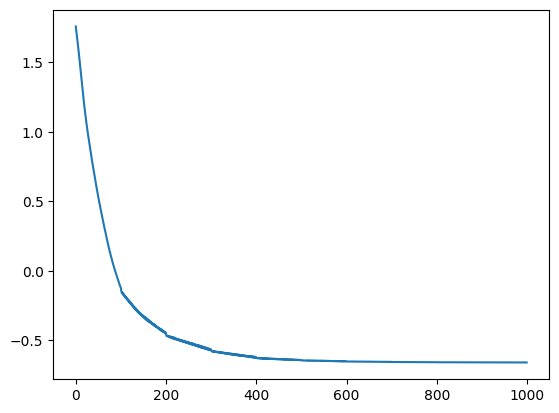

In [13]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [14]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-4.3966e-01, -9.8832e-01, -1.4476e+00, -1.7701e+00, -1.0662e+00,
         -1.1094e+00, -6.1896e-01, -1.9418e-03, -5.3497e-01, -1.7292e-05,
         -3.1132e-05, -3.1503e-01, -2.2812e-01,  1.7465e+00,  5.5289e-01,
          6.0925e-01,  1.3688e-05, -7.7666e-05,  6.1836e-05, -1.4499e-05,
          1.8864e-05, -1.1768e-05,  1.6971e-05,  2.8645e-05, -3.8542e-06,
         -1.5112e-05, -9.9619e-05,  2.1199e-05, -1.2454e-05,  1.6492e-05,
          1.1691e-05,  1.6886e-05,  4.1457e-05,  8.3224e-06,  1.0064e-05,
          3.0259e-05,  1.2262e-05, -3.4582e-05, -1.1672e-05,  5.3490e-05,
          7.3168e-05, -4.9488e-06,  1.2961e-05, -9.4913e-06,  8.8041e-05,
         -9.2930e-05, -2.9156e-05, -2.9151e-05,  2.0442e-05,  1.4083e-05,
         -8.2685e-05,  2.5497e-05,  4.3412e-05, -2.2404e-05,  7.3525e-05,
          3.5107e-02, -1.7741e-05, -3.7725e-05, -3.8150e-06, -1.4352e-05,
          7.9218e-05, -9.0756e-05, -4.5018e-01,  1.5483e-05, -9.8475e-06,
         -7.3509e-06, -1.3632e-05, -1.

tensor([[-4.3966e-01, -9.8832e-01, -1.4476e+00, -1.7701e+00, -1.0662e+00,
         -1.1094e+00, -6.1896e-01, -1.9418e-03, -5.3497e-01, -1.7292e-05,
         -3.1132e-05, -3.1503e-01, -2.2812e-01,  1.7465e+00,  5.5289e-01,
          6.0925e-01,  1.3688e-05, -7.7666e-05,  6.1836e-05, -1.4499e-05,
          1.8864e-05, -1.1768e-05,  1.6971e-05,  2.8645e-05, -3.8542e-06,
         -1.5112e-05, -9.9619e-05,  2.1199e-05, -1.2454e-05,  1.6492e-05,
          1.1691e-05,  1.6886e-05,  4.1457e-05,  8.3224e-06,  1.0064e-05,
          3.0259e-05,  1.2262e-05, -3.4582e-05, -1.1672e-05,  5.3490e-05,
          7.3168e-05, -4.9488e-06,  1.2961e-05, -9.4913e-06,  8.8041e-05,
         -9.2930e-05, -2.9156e-05, -2.9151e-05,  2.0442e-05,  1.4083e-05,
         -8.2685e-05,  2.5497e-05,  4.3412e-05, -2.2404e-05,  7.3525e-05,
          3.5107e-02, -1.7741e-05, -3.7725e-05, -3.8150e-06, -1.4352e-05,
          7.9218e-05, -9.0756e-05, -4.5018e-01,  1.5483e-05, -9.8475e-06,
         -7.3509e-06, -1.3632e-05, -1.

tensor([[-5.0284e-01, -1.1532e+00, -1.5644e+00, -1.6999e+00, -1.1317e+00,
         -1.3114e+00, -8.4368e-01, -3.7707e-01, -8.6803e-02,  1.7032e-06,
         -8.3236e-06, -4.2611e-01, -3.3758e-01,  1.7506e+00,  4.7723e-01,
          5.5822e-01, -2.7638e-06, -3.4769e-07, -5.9965e-06, -4.1041e-06,
         -1.5015e-06,  6.9721e-07, -1.1377e-06,  6.1392e-05,  1.1192e-05,
          1.0687e-06, -2.6583e-05, -1.8909e-05,  2.1923e-07, -7.1186e-06,
         -1.9269e-06,  1.5702e-06,  2.4626e-05, -9.2363e-07, -1.4739e-06,
         -7.4720e-06,  1.1080e-06,  3.5930e-06, -1.3384e-09,  2.1654e-07,
          7.4188e-06,  2.9058e-06,  9.6158e-07, -3.3089e-06, -3.8943e-06,
          3.2326e-06,  8.1514e-07,  1.1841e-06, -3.5817e-06,  1.1008e-06,
         -1.9484e-06,  2.1554e-07, -3.3895e-06, -3.1218e-06,  5.0837e-06,
          1.2779e-01,  3.6839e-08,  2.7678e-05, -4.0005e-06,  2.0748e-06,
          1.4240e-06,  1.9296e-06, -1.1905e+00, -7.8198e-07,  1.0190e-05,
         -1.5274e-06, -2.5337e-06, -1.

In [16]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1604)

tensor(0.0956)

tensor(0.0040)

tensor(0.0608)

In [17]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[83,  2],
       [ 3, 72]])

array([[88,  0],
       [ 0, 72]])

array([[79,  0],
       [ 1, 80]])

(raylet) [2022-11-16 13:40:50,494 E 19772 19798] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_13-33-57_910226_15871 is over 95% full, available space: 177758208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 13:41:00,500 E 19772 19798] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_13-33-57_910226_15871 is over 95% full, available space: 177610752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 13:41:10,507 E 19772 19798] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_13-33-57_910226_15871 is over 95% full, available space: 175853568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 13:41:20,513 E 19772 19798] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_13-33-57_910226_15871 is over 95% full, available space: 175693824; capacity: 29394726912. Object creation will fail i

In [79]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,prior:],p=1,dim=0))
    
            l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_2_regularization = lambda3* torch.sum(all_linear234_params.pow(2))
            
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lambda3": tune.choice([0.001,0.002,0.003]),
        "lr":tune.choice([0.6,0.7,0.8])
         "eta": tune.choice([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_19582_00000,TERMINATED,10.224.0.12:30038,0.6,0.05,0.002,0.6,1,15.6082,0.903835
train_model_19582_00001,TERMINATED,10.224.0.12:30709,0.3,0.05,0.002,0.8,1,15.0181,0.913259
train_model_19582_00002,TERMINATED,10.224.0.12:30712,0.8,0.05,0.002,0.8,1,15.3292,0.93884
train_model_19582_00003,TERMINATED,10.224.0.12:30713,0.2,0.04,0.002,0.6,1,15.6536,0.870144
train_model_19582_00004,TERMINATED,10.224.0.12:30715,0.9,0.05,0.002,0.6,1,15.3682,0.923823
train_model_19582_00005,TERMINATED,10.224.0.12:30717,0.6,0.05,0.002,0.8,1,15.8659,0.934689
train_model_19582_00006,TERMINATED,10.224.0.12:30719,0.4,0.05,0.002,0.6,1,15.2023,0.901525
train_model_19582_00007,TERMINATED,10.224.0.12:30721,0.8,0.05,0.002,0.7,1,15.5533,0.937378
train_model_19582_00008,TERMINATED,10.224.0.12:30723,0.6,0.04,0.002,0.6,1,15.2225,0.886049
train_model_19582_00009,TERMINATED,10.224.0.12:30725,0.5,0.05,0.002,0.7,1,16.7432,0.919858


Result for train_model_19582_00000:
  date: 2022-11-13_19-41-41
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9038350085092874
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.608227014541626
  time_this_iter_s: 15.608227014541626
  time_total_s: 15.608227014541626
  timestamp: 1668339701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00000'
  warmup_time: 0.003755807876586914
  
Result for train_model_19582_00000:
  date: 2022-11-13_19-41-41
  done: true
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  experiment_tag: 0_eta=0.6000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9038350085092874
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.608227014541626
  time_this_iter_s: 15.608227014541626
  time_total_s: 15.608227014541626
  timestamp: 1668339701
  time

Result for train_model_19582_00018:
  date: 2022-11-13_19-41-44
  done: true
  experiment_id: e51363b3e2b5465b95449f7362873ef6
  experiment_tag: 18_eta=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8928210271636029
  node_ip: 10.224.0.12
  pid: 30743
  time_since_restore: 14.891647100448608
  time_this_iter_s: 14.891647100448608
  time_total_s: 14.891647100448608
  timestamp: 1668339704
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00018'
  warmup_time: 0.0063664913177490234
  
Result for train_model_19582_00004:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: 615a8fba64514db1bc75540757779b25
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9238229154288717
  node_ip: 10.224.0.12
  pid: 30715
  time_since_restore: 15.368163108825684
  time_this_iter_s: 15.368163108825684
  time_total_s: 15.368163108825684
  timestamp: 1668339705
  ti

Result for train_model_19582_00013:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: 32d0103f3b6a47759d73e8170b5d1d9d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8837511218000949
  node_ip: 10.224.0.12
  pid: 30733
  time_since_restore: 15.725363969802856
  time_this_iter_s: 15.725363969802856
  time_total_s: 15.725363969802856
  timestamp: 1668339705
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00013'
  warmup_time: 0.004391193389892578
  
Result for train_model_19582_00003:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8701443631752553
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 15.653641939163208
  time_this_iter_s: 15.653641939163208
  time_total_s: 15.653641939163208
  timestamp: 1668339705
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_0000

Result for train_model_19582_00010:
  date: 2022-11-13_19-41-46
  done: true
  experiment_id: d58d05451c1042b1b257224d5be3d635
  experiment_tag: 10_eta=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787062054681399
  node_ip: 10.224.0.12
  pid: 30727
  time_since_restore: 16.42131233215332
  time_this_iter_s: 16.42131233215332
  time_total_s: 16.42131233215332
  timestamp: 1668339706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00010'
  warmup_time: 0.005919218063354492
  
Result for train_model_19582_00009:
  date: 2022-11-13_19-41-46
  done: false
  experiment_id: 6d5f2a00c8694576912351b506df35a3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9198575922374144
  node_ip: 10.224.0.12
  pid: 30725
  time_since_restore: 16.743216276168823
  time_this_iter_s: 16.743216276168823
  time_total_s: 16.743216276168823
  timestamp: 1668339706
  timest

Result for train_model_19582_00044:
  date: 2022-11-13_19-41-59
  done: true
  experiment_id: 4504451f4bdb4c2ba40132314f89cfaf
  experiment_tag: 44_eta=0.7000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8912289920640397
  node_ip: 10.224.0.12
  pid: 30755
  time_since_restore: 13.948164463043213
  time_this_iter_s: 13.948164463043213
  time_total_s: 13.948164463043213
  timestamp: 1668339719
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00044'
  warmup_time: 0.004948616027832031
  
Result for train_model_19582_00036:
  date: 2022-11-13_19-41-59
  done: false
  experiment_id: c4fc08834d4e41a0b48a26d5bdf21209
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8776883319989418
  node_ip: 10.224.0.12
  pid: 30745
  time_since_restore: 14.289895296096802
  time_this_iter_s: 14.289895296096802
  time_total_s: 14.289895296096802
  timestamp: 1668339719
  tim

Result for train_model_19582_00052:
  date: 2022-11-13_19-41-59
  done: false
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8537814984781201
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 14.222955226898193
  time_this_iter_s: 14.222955226898193
  time_total_s: 14.222955226898193
  timestamp: 1668339719
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00052'
  warmup_time: 0.00892782211303711
  
Result for train_model_19582_00052:
  date: 2022-11-13_19-41-59
  done: true
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  experiment_tag: 52_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8537814984781201
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 14.222955226898193
  time_this_iter_s: 14.222955226898193
  time_total_s: 14.222955226898193
  timestamp: 1668339719
  time

Result for train_model_19582_00060:
  date: 2022-11-13_19-42-00
  done: false
  experiment_id: aaf4c6a92a754904a0c95546a1a37c11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132586620012058
  node_ip: 10.224.0.12
  pid: 30759
  time_since_restore: 14.497702598571777
  time_this_iter_s: 14.497702598571777
  time_total_s: 14.497702598571777
  timestamp: 1668339720
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00060'
  warmup_time: 0.0057179927825927734
  
Result for train_model_19582_00060:
  date: 2022-11-13_19-42-00
  done: true
  experiment_id: aaf4c6a92a754904a0c95546a1a37c11
  experiment_tag: 60_eta=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132586620012058
  node_ip: 10.224.0.12
  pid: 30759
  time_since_restore: 14.497702598571777
  time_this_iter_s: 14.497702598571777
  time_total_s: 14.497702598571777
  timestamp: 1668339720
  ti

Result for train_model_19582_00071:
  date: 2022-11-13_19-42-12
  done: true
  experiment_id: 4504451f4bdb4c2ba40132314f89cfaf
  experiment_tag: 71_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30755
  time_since_restore: 13.73396611213684
  time_this_iter_s: 13.73396611213684
  time_total_s: 13.73396611213684
  timestamp: 1668339732
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00071'
  warmup_time: 0.004948616027832031
  
Result for train_model_19582_00064:
  date: 2022-11-13_19-42-12
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.900615652169505
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.931142330169678
  time_this_iter_s: 15.931142330169678
  time_total_s: 15.931142330169678
  timestamp: 1668339732
  timeste

Result for train_model_19582_00073:
  date: 2022-11-13_19-42-13
  done: false
  experiment_id: 0ff1075ea77349f4ba1f68b2e6659866
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764608699768978
  node_ip: 10.224.0.12
  pid: 30761
  time_since_restore: 14.198606729507446
  time_this_iter_s: 14.198606729507446
  time_total_s: 14.198606729507446
  timestamp: 1668339733
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00073'
  warmup_time: 0.004583120346069336
  
Result for train_model_19582_00073:
  date: 2022-11-13_19-42-13
  done: true
  experiment_id: 0ff1075ea77349f4ba1f68b2e6659866
  experiment_tag: 73_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764608699768978
  node_ip: 10.224.0.12
  pid: 30761
  time_since_restore: 14.198606729507446
  time_this_iter_s: 14.198606729507446
  time_total_s: 14.198606729507446
  timestamp: 1668339733
  tim

Result for train_model_19582_00082:
  date: 2022-11-13_19-42-14
  done: false
  experiment_id: cef25a9105dc44b2bacca2943a792b53
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8861615080399142
  node_ip: 10.224.0.12
  pid: 30751
  time_since_restore: 14.597009420394897
  time_this_iter_s: 14.597009420394897
  time_total_s: 14.597009420394897
  timestamp: 1668339734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00082'
  warmup_time: 0.0067594051361083984
  
Result for train_model_19582_00087:
  date: 2022-11-13_19-42-14
  done: false
  experiment_id: ef954a94298541ce9b2e13aa180f2402
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9373781155581083
  node_ip: 10.224.0.12
  pid: 30729
  time_since_restore: 14.093273878097534
  time_this_iter_s: 14.093273878097534
  time_total_s: 14.093273878097534
  timestamp: 1668339734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_000

Result for train_model_19582_00088:
  date: 2022-11-13_19-42-15
  done: false
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 15.165223598480225
  time_this_iter_s: 15.165223598480225
  time_total_s: 15.165223598480225
  timestamp: 1668339735
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00088'
  warmup_time: 0.00596165657043457
  
Result for train_model_19582_00088:
  date: 2022-11-13_19-42-15
  done: true
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  experiment_tag: 88_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 15.165223598480225
  time_this_iter_s: 15.165223598480225
  time_total_s: 15.165223598480225
  timestamp: 1668339735
  time

Result for train_model_19582_00096:
  date: 2022-11-13_19-42-26
  done: false
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 14.131386280059814
  time_this_iter_s: 14.131386280059814
  time_total_s: 14.131386280059814
  timestamp: 1668339746
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00096'
  warmup_time: 0.0042455196380615234
  
Result for train_model_19582_00096:
  date: 2022-11-13_19-42-26
  done: true
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  experiment_tag: 96_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 14.131386280059814
  time_this_iter_s: 14.131386280059814
  time_total_s: 14.131386280059814
  timestamp: 1668339746
  ti

Result for train_model_19582_00107:
  date: 2022-11-13_19-42-28
  done: false
  experiment_id: 72d74af943354f129db023975758b734
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30719
  time_since_restore: 14.375077724456787
  time_this_iter_s: 14.375077724456787
  time_total_s: 14.375077724456787
  timestamp: 1668339748
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00107'
  warmup_time: 0.006102085113525391
  
Result for train_model_19582_00107:
  date: 2022-11-13_19-42-28
  done: true
  experiment_id: 72d74af943354f129db023975758b734
  experiment_tag: 107_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30719
  time_since_restore: 14.375077724456787
  time_this_iter_s: 14.375077724456787
  time_total_s: 14.375077724456787
  timestamp: 1668339748
  ti

Result for train_model_19582_00116:
  date: 2022-11-13_19-42-28
  done: false
  experiment_id: 12bf8fb0acc041ee9ab512d15b2f7cad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9110363974384406
  node_ip: 10.224.0.12
  pid: 30770
  time_since_restore: 14.329932451248169
  time_this_iter_s: 14.329932451248169
  time_total_s: 14.329932451248169
  timestamp: 1668339748
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00116'
  warmup_time: 0.006588935852050781
  
Result for train_model_19582_00116:
  date: 2022-11-13_19-42-28
  done: true
  experiment_id: 12bf8fb0acc041ee9ab512d15b2f7cad
  experiment_tag: 116_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9110363974384406
  node_ip: 10.224.0.12
  pid: 30770
  time_since_restore: 14.329932451248169
  time_this_iter_s: 14.329932451248169
  time_total_s: 14.329932451248169
  timestamp: 1668339748
  ti

Result for train_model_19582_00123:
  date: 2022-11-13_19-42-30
  done: false
  experiment_id: a38dd6a495794c50bd103159dc5b4ec2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9330645129634048
  node_ip: 10.224.0.12
  pid: 30768
  time_since_restore: 14.76933741569519
  time_this_iter_s: 14.76933741569519
  time_total_s: 14.76933741569519
  timestamp: 1668339750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00123'
  warmup_time: 0.005151510238647461
  
Result for train_model_19582_00123:
  date: 2022-11-13_19-42-30
  done: true
  experiment_id: a38dd6a495794c50bd103159dc5b4ec2
  experiment_tag: 123_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9330645129634048
  node_ip: 10.224.0.12
  pid: 30768
  time_since_restore: 14.76933741569519
  time_this_iter_s: 14.76933741569519
  time_total_s: 14.76933741569519
  timestamp: 1668339750
  timestep

Result for train_model_19582_00130:
  date: 2022-11-13_19-42-40
  done: false
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660274944141146
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 13.976139783859253
  time_this_iter_s: 13.976139783859253
  time_total_s: 13.976139783859253
  timestamp: 1668339760
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00130'
  warmup_time: 0.0042455196380615234
  
Result for train_model_19582_00130:
  date: 2022-11-13_19-42-40
  done: true
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  experiment_tag: 130_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660274944141146
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 13.976139783859253
  time_this_iter_s: 13.976139783859253
  time_total_s: 13.976139783859253
  timestamp: 1668339760
  t

Result for train_model_19582_00137:
  date: 2022-11-13_19-42-42
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8822124211536979
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 14.732045412063599
  time_this_iter_s: 14.732045412063599
  time_total_s: 14.732045412063599
  timestamp: 1668339762
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00137'
  warmup_time: 0.003755807876586914
  
Result for train_model_19582_00137:
  date: 2022-11-13_19-42-42
  done: true
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  experiment_tag: 137_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8822124211536979
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 14.732045412063599
  time_this_iter_s: 14.732045412063599
  time_total_s: 14.732045412063599
  timestamp: 1668339762
  ti

Result for train_model_19582_00151:
  date: 2022-11-13_19-42-43
  done: false
  experiment_id: dee32cc82fd044a1a5f94122a97e2b96
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.911984526647968
  node_ip: 10.224.0.12
  pid: 30739
  time_since_restore: 13.678586721420288
  time_this_iter_s: 13.678586721420288
  time_total_s: 13.678586721420288
  timestamp: 1668339763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00151'
  warmup_time: 0.005663156509399414
  
Result for train_model_19582_00151:
  date: 2022-11-13_19-42-43
  done: true
  experiment_id: dee32cc82fd044a1a5f94122a97e2b96
  experiment_tag: 151_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.911984526647968
  node_ip: 10.224.0.12
  pid: 30739
  time_since_restore: 13.678586721420288
  time_this_iter_s: 13.678586721420288
  time_total_s: 13.678586721420288
  timestamp: 1668339763
  time

Result for train_model_19582_00158:
  date: 2022-11-13_19-42-44
  done: false
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9408935955242154
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 13.208621263504028
  time_this_iter_s: 13.208621263504028
  time_total_s: 13.208621263504028
  timestamp: 1668339764
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00158'
  warmup_time: 0.00596165657043457
  
Result for train_model_19582_00158:
  date: 2022-11-13_19-42-44
  done: true
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  experiment_tag: 158_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9408935955242154
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 13.208621263504028
  time_this_iter_s: 13.208621263504028
  time_total_s: 13.208621263504028
  timestamp: 1668339764
  tim

2022-11-13 19:42:46,709	INFO tune.py:758 -- Total run time: 83.50 seconds (83.27 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
19582_00000         0.903835         15.608227  True            None   
19582_00001         0.913259         15.018144  True            None   
19582_00002         0.938840         15.329222  True            None   
19582_00003         0.870144         15.653642  True            None   
19582_00004         0.923823         15.368163  True            None   
...                      ...               ...   ...             ...   
19582_00155         0.867670         13.389029  True            None   
19582_00156         0.911089         13.087188  True            None   
19582_00157         0.853781         13.331625  True            None   
19582_00158         0.940894         13.208621  True            None   
19582_00159         0.923823         11.805140  True            None   

     

In [80]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9410284405516173


{'lambda1': 0.05, 'lambda2': 0.002, 'eta': 0.9, 'lr': 0.8}

In [81]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=1,dim=0))
    
    l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

    l2_2_regularization = lambda3* torch.sum(all_linear23_params.pow(2))
            
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.4325, grad_fn=<AddBackward0>)

tensor(0.1431, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0155, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1437, grad_fn=<BinaryCrossEntropyBackward0>)

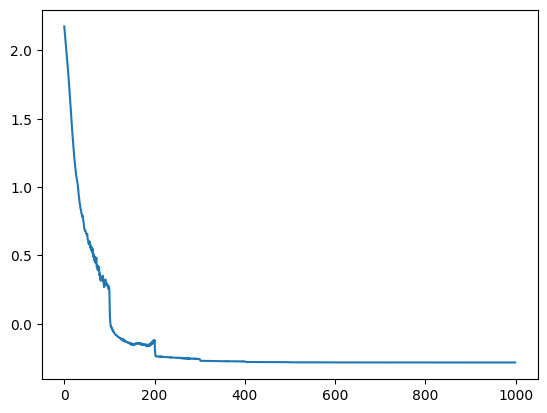

In [82]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [83]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2729e-01, -1.2070e-01, -1.8623e-01, -1.1179e-01, -1.7567e-01,
          1.3397e-01, -1.7035e-01, -9.6188e-02,  1.4363e-01,  2.0452e-01,
         -1.8745e-06, -4.8124e-08,  2.1316e-06, -2.8661e-03,  3.1761e-06,
          1.1932e-06, -1.1070e-06,  2.1226e-07, -2.0428e-06, -1.7662e-06,
          1.3885e-06, -4.8231e-07, -3.5084e-06, -6.3221e-05,  2.6613e-06,
         -2.7282e-07,  5.7752e-07, -2.7110e-06, -3.1199e-06, -1.0121e-06,
          3.6760e-06,  1.9187e-07,  1.4116e-02,  2.2539e-06, -2.1629e-06,
         -1.8518e-06,  2.0971e-06,  2.5885e-06, -1.4399e-06,  1.7137e-06,
          1.8175e-06, -2.8717e-07,  4.5464e-09,  3.1647e-06, -3.4453e-06,
         -9.2393e-07, -1.9261e-06, -1.3048e-07, -1.2538e-06,  2.7852e-06,
          8.4658e-07, -3.6924e-06, -2.1638e-06, -8.3108e-07,  1.7998e-06,
         -2.2454e-07,  2.8836e-06,  2.8277e-06, -4.2300e-07, -1.6687e-06,
         -7.6285e-07, -9.4721e-07, -1.5197e-02,  1.3575e-06, -8.4698e-07,
          2.4219e-06,  3.3457e-06,  3.

tensor([[-1.2729e-01, -1.2070e-01, -1.8623e-01, -1.1179e-01, -1.7567e-01,
          1.3397e-01, -1.7035e-01, -9.6188e-02,  1.4363e-01,  2.0452e-01,
         -1.8745e-06, -4.8124e-08,  2.1316e-06, -2.8661e-03,  3.1761e-06,
          1.1932e-06, -1.1070e-06,  2.1226e-07, -2.0428e-06, -1.7662e-06,
          1.3885e-06, -4.8231e-07, -3.5084e-06, -6.3221e-05,  2.6613e-06,
         -2.7282e-07,  5.7752e-07, -2.7110e-06, -3.1199e-06, -1.0121e-06,
          3.6760e-06,  1.9187e-07,  1.4116e-02,  2.2539e-06, -2.1629e-06,
         -1.8518e-06,  2.0971e-06,  2.5885e-06, -1.4399e-06,  1.7137e-06,
          1.8175e-06, -2.8717e-07,  4.5464e-09,  3.1647e-06, -3.4453e-06,
         -9.2393e-07, -1.9261e-06, -1.3048e-07, -1.2538e-06,  2.7852e-06,
          8.4658e-07, -3.6924e-06, -2.1638e-06, -8.3108e-07,  1.7998e-06,
         -2.2454e-07,  2.8836e-06,  2.8277e-06, -4.2300e-07, -1.6687e-06,
         -7.6285e-07, -9.4721e-07, -1.5197e-02,  1.3575e-06, -8.4698e-07,
          2.4219e-06,  3.3457e-06,  3.

tensor([[-1.5949e-01, -1.5985e-01, -2.1366e-01, -1.4209e-01,  2.0299e-01,
         -1.5159e-01, -2.3908e-01, -1.3098e-01, -2.0774e-01, -2.5107e-01,
         -5.1428e-07, -1.7675e-08,  2.2025e-07,  2.3199e-02, -7.8276e-09,
         -8.6585e-08,  7.4174e-09,  2.5426e-07,  2.2036e-07, -1.1373e-07,
          3.0776e-08, -2.1777e-08,  2.8894e-08,  3.3411e-03, -9.5327e-07,
         -6.1641e-09, -6.2706e-07,  6.1332e-08, -7.2128e-07, -1.2985e-07,
         -7.6627e-08, -2.2828e-09,  1.8206e-02,  9.6265e-07, -9.1774e-09,
         -4.9530e-07,  1.2470e-07, -1.2491e-08, -3.5349e-07,  1.1643e-06,
          2.5740e-07,  1.4291e-08, -2.3457e-06,  4.8340e-09, -6.0685e-08,
          1.7710e-07, -5.3653e-08,  1.7868e-08, -6.1220e-07,  6.3676e-07,
         -2.0460e-08, -2.2033e-07,  2.8037e-08,  9.7984e-07,  3.6418e-07,
         -6.9050e-07, -2.3602e-08,  1.7321e-07, -3.3588e-08, -1.1508e-07,
          4.3530e-07, -5.9793e-08, -1.5695e-02, -8.2820e-08, -1.5277e-07,
         -2.7201e-07, -2.2251e-07,  5.

In [84]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8629e-01, 1.6649e-01, 2.2053e-02, 9.8247e-01, 9.4854e-01, 9.9003e-01,
        9.6850e-01, 8.9416e-05, 9.3342e-01, 9.8977e-01, 1.2230e-02, 8.9069e-01,
        7.5648e-01, 6.0270e-01, 2.0401e-02, 3.8413e-02, 7.7234e-01, 9.1466e-02,
        9.8744e-01, 9.2146e-01, 1.9258e-01, 9.8354e-01, 8.1597e-01, 9.8514e-01,
        1.3964e-01, 9.7900e-01, 1.1062e-01, 2.2658e-01, 8.9243e-01, 1.4245e-02,
        6.1158e-01, 4.3107e-04, 5.9352e-04, 6.1594e-03, 1.9662e-01, 1.8347e-01,
        4.2697e-01, 9.7678e-01, 1.9961e-02, 4.6458e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.])

tensor([0.0114, 0.9790, 0.1355, 0.2498, 0.4274, 0.1636, 0.0619, 0.9448, 0.0067,
        0.0049, 0.3218, 0.2291, 0.0038, 0.9991, 0.9958, 0.8763, 0.0738, 0.0813,
        0.0111, 0.9962, 0.9585, 0.9469, 0.0052, 0.9949, 0.0153, 0.0033, 0.5578,
        0.1334, 0.0133, 0.9656, 0.5137, 0.1663, 0.9996, 0.0793, 0.0071, 0.9868,
        0.2085, 0.7230, 0.9966, 0.9934], grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1.])

tensor([9.7635e-01, 9.8503e-01, 2.7939e-01, 9.7825e-01, 1.1860e-01, 9.2438e-01,
        1.9617e-01, 4.3819e-01, 9.8625e-01, 7.4546e-02, 8.9738e-01, 1.0644e-04,
        9.9145e-01, 3.5298e-04, 9.7296e-01, 1.1837e-03, 9.8572e-01, 9.9367e-01,
        6.5174e-01, 9.3205e-01, 9.8697e-01, 1.6859e-02, 9.0750e-01, 3.5625e-03,
        1.9075e-02, 1.5107e-01, 9.9228e-01, 9.9540e-01, 9.8395e-01, 4.1688e-01,
        8.3027e-01, 1.2363e-01, 9.5675e-02, 3.2152e-01, 4.7448e-02, 4.9648e-03,
        1.2046e-02, 5.3272e-01, 1.2116e-02, 7.8584e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.])

In [85]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[58,  5],
       [ 5, 52]])

0.9122807017543859

0.9206349206349206

0.9166666666666666

0.9122807017543859

0.9122807017543859

In [86]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[20,  2],
       [ 0, 18]])

1.0

0.9090909090909091

array([[18,  2],
       [ 5, 15]])

0.75

0.9

array([[20,  1],
       [ 0, 19]])

1.0

0.9523809523809523

In [87]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.2729214e-01, -1.2069799e-01, -1.8623360e-01, -1.1179250e-01,
        -1.7567100e-01,  1.3397416e-01, -1.7035024e-01, -9.6187815e-02,
         1.4363399e-01,  2.0452313e-01, -1.8745031e-06, -4.8123944e-08,
         2.1315864e-06, -2.8660903e-03,  3.1761347e-06,  1.1931995e-06,
        -1.1069817e-06,  2.1225621e-07, -2.0427522e-06, -1.7662397e-06,
         1.3884879e-06, -4.8230805e-07, -3.5084222e-06, -6.3220883e-05,
         2.6612884e-06, -2.7281740e-07,  5.7752453e-07, -2.7109975e-06,
        -3.1199042e-06, -1.0121394e-06,  3.6760464e-06,  1.9186642e-07,
         1.4116176e-02,  2.2539100e-06, -2.1628769e-06, -1.8517701e-06,
         2.0971293e-06,  2.5884574e-06, -1.4398507e-06,  1.7137371e-06,
         1.8175356e-06, -2.8717062e-07,  4.5464312e-09,  3.1646500e-06,
        -3.4452751e-06, -9.2393054e-07, -1.9260990e-06, -1.3048047e-07,
        -1.2538006e-06,  2.7851688e-06,  8.4657836e-07, -3.6923536e-06,
        -2.1637713e-06, -8.3108029e-07,  1.7998231e-06, -2.24542

array([[-1.2729214e-01, -1.2069799e-01, -1.8623360e-01, -1.1179250e-01,
        -1.7567100e-01,  1.3397416e-01, -1.7035024e-01, -9.6187815e-02,
         1.4363399e-01,  2.0452313e-01, -1.8745031e-06, -4.8123944e-08,
         2.1315864e-06, -2.8660903e-03,  3.1761347e-06,  1.1931995e-06,
        -1.1069817e-06,  2.1225621e-07, -2.0427522e-06, -1.7662397e-06,
         1.3884879e-06, -4.8230805e-07, -3.5084222e-06, -6.3220883e-05,
         2.6612884e-06, -2.7281740e-07,  5.7752453e-07, -2.7109975e-06,
        -3.1199042e-06, -1.0121394e-06,  3.6760464e-06,  1.9186642e-07,
         1.4116176e-02,  2.2539100e-06, -2.1628769e-06, -1.8517701e-06,
         2.0971293e-06,  2.5884574e-06, -1.4398507e-06,  1.7137371e-06,
         1.8175356e-06, -2.8717062e-07,  4.5464312e-09,  3.1646500e-06,
        -3.4452751e-06, -9.2393054e-07, -1.9260990e-06, -1.3048047e-07,
        -1.2538006e-06,  2.7851688e-06,  8.4657836e-07, -3.6923536e-06,
        -2.1637713e-06, -8.3108029e-07,  1.7998231e-06, -2.24542

array([[-1.59486875e-01, -1.59852237e-01, -2.13664025e-01,
        -1.42089859e-01,  2.02985883e-01, -1.51586041e-01,
        -2.39080057e-01, -1.30980670e-01, -2.07740128e-01,
        -2.51066923e-01, -5.14277360e-07, -1.76746546e-08,
         2.20248367e-07,  2.31987648e-02, -7.82756615e-09,
        -8.65850893e-08,  7.41739115e-09,  2.54256634e-07,
         2.20359638e-07, -1.13725847e-07,  3.07763948e-08,
        -2.17772218e-08,  2.88941280e-08,  3.34111182e-03,
        -9.53268795e-07, -6.16411722e-09, -6.27055726e-07,
         6.13324858e-08, -7.21284835e-07, -1.29850292e-07,
        -7.66269466e-08, -2.28276820e-09,  1.82059165e-02,
         9.62645686e-07, -9.17736553e-09, -4.95304050e-07,
         1.24700080e-07, -1.24912338e-08, -3.53488218e-07,
         1.16430999e-06,  2.57399023e-07,  1.42905359e-08,
        -2.34571917e-06,  4.83402030e-09, -6.06846342e-08,
         1.77102649e-07, -5.36528617e-08,  1.78681763e-08,
        -6.12202143e-07,  6.36762195e-07, -2.04595931e-0

In [88]:
threshold=0.12
mcl_w_1=np.zeros(p)
mcl_w_2=np.zeros(p)
mcl_w_3=np.zeros(p)

for i in range(p):
    mcl_w_1[i]=model_1_weight[0,i]
    mcl_w_2[i]=model_2_weight[0,i]
    mcl_w_3[i]=model_3_weight[0,i]

max_mcl_w_1=max(abs(mcl_w_1))
max_mcl_w_2=max(abs(mcl_w_2))
max_mcl_w_3=max(abs(mcl_w_3))

for i in range(p):
    if (abs(model_1_weight[0,i]))<=threshold*max_mcl_w_1:
        model_1_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        
for i in range(p):
    if (abs(model_2_weight[0,i]))<=threshold*max_mcl_w_2:
        model_2_weight[0,i]=0
    else:
        model_2_weight[0,i]=model_2_weight[0,i]
        
for i in range(p):
    if (abs(model_3_weight[0,i]))<=threshold*max_mcl_w_3:
        model_3_weight[0,i]=0
    else:
        model_3_weight[0,i]=model_3_weight[0,i]
        

index_1=np.nonzero(model_1_weight)[1]
index_2=np.nonzero(model_2_weight)[1]
index_3=np.nonzero(model_3_weight)[1]
index_1+1
index_2+1
index_3+1
len(index_1)
len(index_2)
len(index_3)

array([[-0.12729214, -0.12069799, -0.1862336 , -0.1117925 , -0.175671  ,
         0.13397416, -0.17035024, -0.09618782,  0.14363399,  0.20452313,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10

In [89]:
index_1=np.nonzero(model_1_weight)[1]
index_1=index_1.tolist()
index_1=set(index_1)
beta_1=np.array(beta_1)
trueindex_1=np.where(beta_1!=0)[0]
trueindex_1=trueindex_1.tolist()
trueindex_1=set(trueindex_1)

index_2=np.nonzero(model_2_weight)[1]
index_2=index_2.tolist()
index_2=set(index_2)
trueindex_2=np.where(beta_2!=0)[0]
trueindex_2=trueindex_2.tolist()
trueindex_2=set(trueindex_2)

index_3=np.nonzero(model_3_weight)[1]
index_3=index_3.tolist()
index_3=set(index_3)
trueindex_3=np.where(beta_3!=0)[0]
trueindex_3=trueindex_3.tolist()
trueindex_3=set(trueindex_3)


TP_1=len(trueindex_1.intersection(index_1))
FP_1=len(index_1.difference(trueindex_1))
FN_1=len(trueindex_1)-TP_1
TN_1=p-len(trueindex_1)-FP_1

TP_2=len(trueindex_2.intersection(index_2))
FP_2=len(index_2.difference(trueindex_2))
FN_2=len(trueindex_2)-TP_2
TN_2=p-len(trueindex_2)-FP_2

TP_3=len(trueindex_3.intersection(index_3))
FP_3=len(index_3.difference(trueindex_3))
FN_3=len(trueindex_3)-TP_3
TN_3=p-len(trueindex_3)-FP_3

vsSEN=(TP_1+TP_2+TP_3)/(TP_1+FN_1+TP_2+FN_2+TP_3+FN_3)#vsSEN.
vsSPE=(TN_1+TN_2+TN_3)/(TN_1+FP_1+TN_2+FP_2+TN_3+FP_3)#vsSPE
vsGM=math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP_1+FN_1+FP_2+FN_2+FP_3+FN_3)/(p*300)#vsMR
vsCCR=1-vsMR#vsCCR
vsSEN
vsSPE
vsGM

1.0

1.0

1.0

1.0

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}